In [38]:
import torch
import requests
import torch.nn.functional as plt
import torch.nn.functional as F


In [39]:
# load text file:

google_colab = False
# URL of the raw file from GitHub
if google_colab == True:
    url = 'https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt'
    # Send a GET request to fetch the file content
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        text_data = response.text
        #print(text_data)
    else:
        print(f"Failed to fetch the file. Status code: {response.status_code}")

    print(f"{type(text_data)}")
    words = text_data.split("\n")
    print(f"word length of text data: {len(words)}")

else:
    # read in all the words
    words = open('names.txt', 'r').read().splitlines()
    print(f"words: {words[:5]}")
    print(f"word length of text data: {len(words)}")
    

words: ['emma', 'olivia', 'ava', 'isabella', 'sophia']
word length of text data: 32033


In [40]:
# Build the vocabulary of characters and mappings to/from integers:
#--------------------------------------------
# in this dataset:
# Total vocab size is 27
    # 26 unique charcters in english 
    # One special chatacter "."




chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

vocab_size = len(itos)




print(f"indx to char:{itos}")
print(f"vocab size: {vocab_size}")

indx to char:{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab size: 27


In [41]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [79]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g) 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [44]:
# Training Loop:
#------------------------------

max_steps = 5000
batch_size = 32
lossi = []


for i in range(max_steps):

    #minbatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator= g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batchs

    #forward Pass:
    emb = C[Xb]                 # emb chr into vector(32,3,10)
    embcat = emb.view(emb.shape[0],-1)       # voncat the vectors(32,30)
    hpreact = embcat @ W1 + b1    # (32,200)
    h = torch.tanh(hpreact)     # (32,200)
    logits = h @ W2 + b2        # (32,27)
    loss = F.cross_entropy(logits, Yb)

    #backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()

    #weight update:
    lr = 0.1 if i < 500 else 0.01      # step lr decay
    for p in parameters:
        p.data += -lr * p.grad

    # track status:
    if i % 500== 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    
    # plot data
    lossi.append(loss.log10().item())





      0/   5000: 27.8817
    500/   5000: 6.6551
   1000/   5000: 4.1455
   1500/   5000: 4.9696
   2000/   5000: 3.9851
   2500/   5000: 4.3726
   3000/   5000: 3.6716
   3500/   5000: 3.2918
   4000/   5000: 3.4521
   4500/   5000: 3.5971


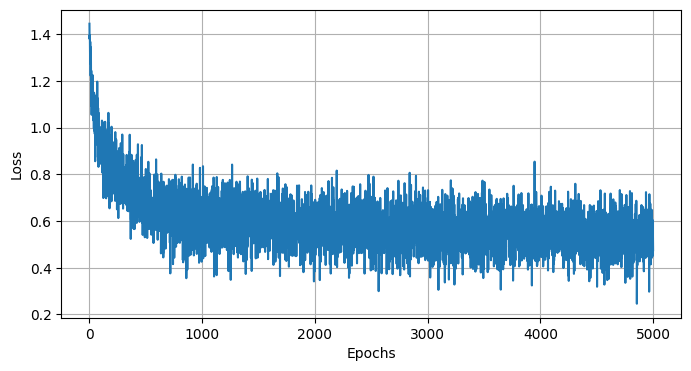

In [ ]:

import matplotlib.pyplot as plt
# Plot loss vs epochs
plt.figure(figsize=(8, 4))  # Set the width and height in inches
plt.plot(lossi)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
@torch.no_grad()   # decorator will disable gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f"{split} {loss.item():.4f}")

split_loss('train')
split_loss('val')

train 3.4380
val 3.4333


In [77]:
# from the training loss we can say that our model is wrongly configured:
# as the starting loss is very high 27 at 1st iteration

# as per the calculation 
# prob of any char to be in output is 1/27
# if we will take -ive of log of prob 
# it will come around: 3.29
# at initalusation all char have equal prob to come next. uniforma prob

# in the above case where loss is 27 
# its shjow that the prob distribution of next char in the seq is unevan and haiving wrong prob values

st_loss = -torch.tensor(1/27.0).log()
print(f"{st_loss =}")

# case 1:
# 4-dim example;
logits = torch.tensor([0.0,0.0,0.0,0.0])   # le it all the logits values are equal and 0
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log()   # let say my actual out pyut is of index 2
print(f"{logits=}\n{probs=},\n{loss=}")    # so for equal prob of all char to be come in seq 
# here loss is ok 1.38

print(f"------------------------------")
# case 2: 
# 4-dim example;
logits = torch.tensor([0.0,0.0,8.0,0.0])   # let it has high value for true char 
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log()   # let say my actual out pyut is of index 2
print(f"{logits=}\n{probs=},\n{loss=}")   
#here loss is very low  0.001

print(f"------------------------------")
# case 2: 
# 4-dim example;
logits = torch.tensor([10.0,0.0,1.0,5.0])   # let it has high value for other char 
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log()   # let say my actual out pyut is of index 2
print(f"{logits=}\n{probs=},\n{loss=}")    # so for equal prob of all char to be come in seq 
#here loss will become very high


print(f"------------------------------")
# case 2: 
# 4-dim example;
logits = torch.randn(4) * 500   # let it has all the logit values are very high extrem values
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log()   # let say my actual out pyut is of index 2
print(f"{logits=}\n{probs=},\n{loss=}")    # so for equal prob of all char to be come in seq 
#here loss will become infinity


# conclusion:

# so we want logits values roughly 0  when we are initalising the NN


st_loss =tensor(3.2958)
logits=tensor([0., 0., 0., 0.])
probs=tensor([0.2500, 0.2500, 0.2500, 0.2500]),
loss=tensor(1.3863)
------------------------------
logits=tensor([0., 0., 8., 0.])
probs=tensor([3.3513e-04, 3.3513e-04, 9.9899e-01, 3.3513e-04]),
loss=tensor(0.0010)
------------------------------
logits=tensor([10.,  0.,  1.,  5.])
probs=tensor([9.9314e-01, 4.5089e-05, 1.2256e-04, 6.6917e-03]),
loss=tensor(9.0069)
------------------------------
logits=tensor([  39.0013, 1207.2515,  713.9269,  382.7595])
probs=tensor([0., 1., 0., 0.]),
loss=tensor(inf)


In [81]:
# so now will break the training for the 1st epocch and check the logits values:
# Training Loop:
#------------------------------

# as you can see the logits values are very high:
# it need to be near to zero

# tensor([  9.8054, -10.7094, -18.9225,   4.5784,  25.0958,  12.3420,  25.2245,
#           2.3172,  23.1374, -15.8994,  -1.2803, -13.0714,  11.7869,  21.8830,
#         -10.2817, -10.7709,  13.7777,  -7.2771,  -1.5731,  15.3102,  -0.5203,
#         -18.8392,  30.8516,  16.5554, -18.1451,   2.9022, -36.2960],
#        grad_fn=<SelectBackward0>)

      0/   5000: 26.5404


In [83]:
logits[0]

tensor([  9.8054, -10.7094, -18.9225,   4.5784,  25.0958,  12.3420,  25.2245,
          2.3172,  23.1374, -15.8994,  -1.2803, -13.0714,  11.7869,  21.8830,
        -10.2817, -10.7709,  13.7777,  -7.2771,  -1.5731,  15.3102,  -0.5203,
        -18.8392,  30.8516,  16.5554, -18.1451,   2.9022, -36.2960],
       grad_fn=<SelectBackward0>)

In [84]:
# now we will do manupulation in the w and b to reduce the value of logits:
#-----------------------------------------------------------------------------

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# Training Loop:
#------------------------------

max_steps = 5000
batch_size = 32
lossi = []


for i in range(max_steps):

    #minbatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator= g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batchs

    #forward Pass:
    emb = C[Xb]                 # emb chr into vector(32,3,10)
    embcat = emb.view(emb.shape[0],-1)       # voncat the vectors(32,30)
    hpreact = embcat @ W1 + b1    # (32,200)
    h = torch.tanh(hpreact)     # (32,200)
    logits = h @ W2 + b2        # (32,27)
    loss = F.cross_entropy(logits, Yb)

    #backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()

    #weight update:
    lr = 0.1 if i < 500 else 0.01      # step lr decay
    for p in parameters:
        p.data += -lr * p.grad

    # track status:
    if i % 500== 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    
    # plot data
    lossi.append(loss.log10().item())
    break




# now the loss got reduce to 4.15


11897
      0/   5000: 4.1594


In [85]:
logits[0]

tensor([ 9.6681e-01, -1.1914e+00, -2.0867e+00,  4.2690e-01,  2.3077e+00,
         1.2333e+00,  2.6025e+00,  1.7052e-01,  2.1348e+00, -1.5226e+00,
        -6.5428e-04, -1.1943e+00,  1.1500e+00,  2.1714e+00, -1.1405e+00,
        -1.1426e+00,  1.6481e+00, -8.5650e-01, -1.5825e-01,  1.5952e+00,
        -1.8752e-01, -1.6885e+00,  2.9731e+00,  1.6532e+00, -1.8955e+00,
         3.7008e-01, -3.6045e+00], grad_fn=<SelectBackward0>)

In [87]:
# we cant set W2 as 0 in the 1st place:

# now do training for all 

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# Training Loop:
#------------------------------

max_steps = 5000
batch_size = 32
lossi = []


for i in range(max_steps):

    #minbatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator= g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batchs

    #forward Pass:
    emb = C[Xb]                 # emb chr into vector(32,3,10)
    embcat = emb.view(emb.shape[0],-1)       # voncat the vectors(32,30)
    hpreact = embcat @ W1 + b1    # (32,200)
    h = torch.tanh(hpreact)     # (32,200)
    logits = h @ W2 + b2        # (32,27)
    loss = F.cross_entropy(logits, Yb)

    #backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()

    #weight update:
    lr = 0.1 if i < 500 else 0.01      # step lr decay
    for p in parameters:
        p.data += -lr * p.grad

    # track status:
    if i % 500== 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    
    # plot data
    lossi.append(loss.log10().item())



11897
      0/   5000: 4.1594
    500/   5000: 2.9007
   1000/   5000: 2.4570
   1500/   5000: 2.0873
   2000/   5000: 2.3688
   2500/   5000: 2.2147
   3000/   5000: 2.1680
   3500/   5000: 2.5260
   4000/   5000: 1.9915
   4500/   5000: 2.2146


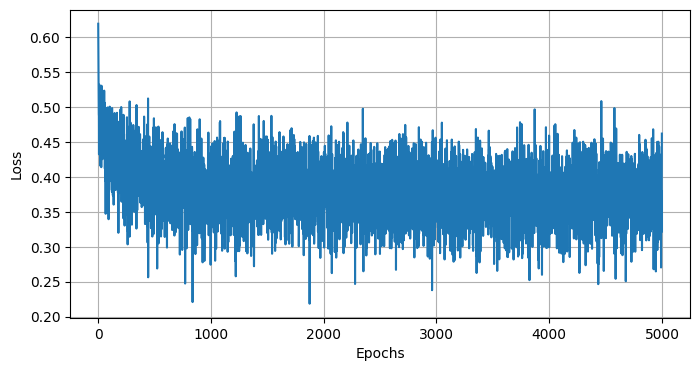

In [88]:

import matplotlib.pyplot as plt
# Plot loss vs epochs
plt.figure(figsize=(8, 4))  # Set the width and height in inches
plt.plot(lossi)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [89]:
@torch.no_grad()   # decorator will disable gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f"{split} {loss.item():.4f}")

split_loss('train')
split_loss('val')

train 2.3525
val 2.3578


In [90]:
# now we can see below changes after properly intialising the weight and baises
# W2 * 0.1 small value
# b2 * 0.0 

# 1. starting loss value got reduce
# 2. loss curve got change from the hockey stick to much curved shape
# 3. the val loss also got imporved.
            # train 2.3525
            # val 2.3578




In [91]:
# 2nd prob in weight initalization
#-----------------------------------------


n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# Training Loop:
#------------------------------

max_steps = 5000
batch_size = 32
lossi = []


for i in range(max_steps):

    #minbatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator= g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batchs

    #forward Pass:
    emb = C[Xb]                 # emb chr into vector(32,3,10)
    embcat = emb.view(emb.shape[0],-1)       # voncat the vectors(32,30)
    hpreact = embcat @ W1 + b1    # (32,200)
    h = torch.tanh(hpreact)     # (32,200)
    logits = h @ W2 + b2        # (32,27)
    loss = F.cross_entropy(logits, Yb)

    #backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()

    #weight update:
    lr = 0.1 if i < 500 else 0.01      # step lr decay
    for p in parameters:
        p.data += -lr * p.grad

    # track status:
    if i % 500== 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    
    # plot data
    lossi.append(loss.log10().item())
    break







11897
      0/   5000: 4.1594


In [100]:
# now logits values are good in 1st iteration 
# now check the the values of h
# h is the activation of the hidden state

h[:5,:]

# here most of the values are 1 or -1 
# bcz the tanh function squshes the input in b/w 1&-1

tensor([[ 0.9971,  0.9999, -1.0000,  0.9119,  0.8863, -0.9997, -1.0000,  1.0000,
          1.0000, -1.0000, -0.9906,  1.0000,  1.0000, -1.0000,  0.9992,  1.0000,
          1.0000,  1.0000, -1.0000, -1.0000,  1.0000,  1.0000, -0.9691, -1.0000,
          0.9997,  0.9987,  1.0000,  1.0000,  0.3237,  0.9854,  1.0000, -0.9034,
         -1.0000, -0.9997,  0.9592, -1.0000,  0.9999,  0.9927,  0.9999,  0.5128,
         -0.9792, -1.0000,  1.0000,  0.9830,  0.1449, -0.9695,  1.0000, -1.0000,
          0.9948, -0.9997, -0.9689, -1.0000, -0.9997,  0.9999,  0.6740, -0.9906,
          1.0000, -1.0000,  0.8690, -1.0000, -0.9341, -0.9999,  0.9999,  1.0000,
         -0.6062,  1.0000,  0.9952, -0.9999, -1.0000,  1.0000,  0.8954, -0.6913,
          0.9213,  0.9823,  0.9980, -1.0000, -1.0000, -0.9753, -0.9978, -1.0000,
         -0.9954, -1.0000, -0.9913, -0.8012, -0.9765,  0.4806,  0.4614,  0.9999,
         -1.0000, -0.9993,  0.9936, -0.2828,  1.0000, -0.9998,  0.9798,  0.8794,
         -1.0000, -0.9915, -

torch.Size([32, 200]) torch.Size([6400])


[]

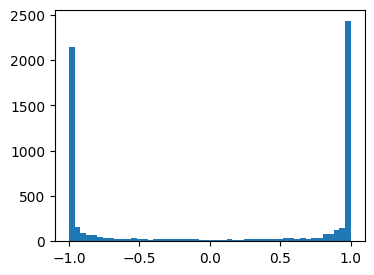

In [113]:
# plot of h
# stratch it one large vector

print(h.shape, h.view(-1).shape)
lst =  h.view(-1).tolist()
plt.figure(figsize=(4, 3))
plt.hist(lst,50)
plt.plot()

# from plot u can see that the most of the values of activation are 1 or -1 bcz of squashing nature of tanh

[]

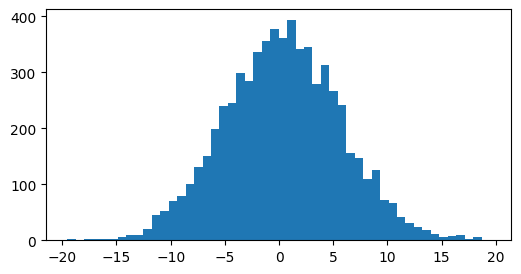

In [117]:
# values before activation triggered
plt.figure(figsize=(6, 3))
plt.hist(hpreact.view(-1).tolist(), 50)
plt.plot()


# from the plot of preactivation values we can see that the range of values are quit broad 
# # from [-20 to +20] 

In [ ]:
# the -1 or +1 values of activation h will effect the value of grad in back propgation 
# it will kill the gradiants (grad = 0)

# from below code you can see at the time of back prop
# activation value will become -1 or +1 
# which will inforce grad to become zero
# self.grad += (1-t**2) * out.grad 


def tanh(self):
        import math
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x)+ 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad      
        out._backward = _backward

        return out

# the basic intustion is that
# for the changes in W and b there will be least changes in the value of loss beach ofv the flat reasons of the tenh oput values.
# the gradiants corrosponding to the 1 or -1 values of activation will get die. 

shape of activation:
torch.Size([32, 200])


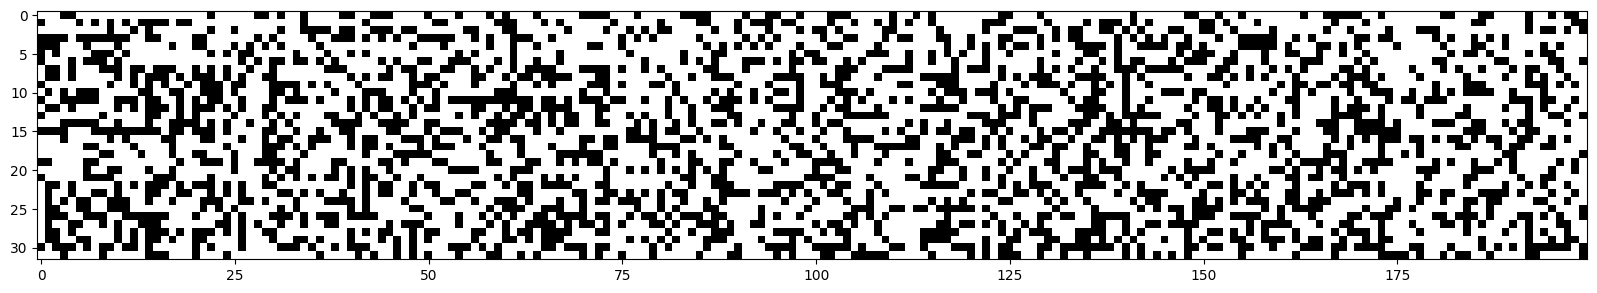

In [122]:
# now we will check (how much values of h are having close 1 values
print(f"shape of activation:\n{h.shape}")
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap= 'gray', interpolation='nearest')
# 32 examples vs 200 output from 200 neurons for each example

# the whit colure shows that the activation of that neuron is haveing value 1 which will kill the gradiants
# if entire coumn is having white colure
# it will ve consider as ded neuron
# which meanse not any example ever activate this neuron in the tanh active reason of tanh (ie the non flat reason)

In [126]:
# solution:
# to fix that we want preactivation 
# hpreact values to be close to zero
# so we will change the W1 and b1 values
# bxz C is already from gausian distribution
#-------------------------------------------------------

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# Training Loop:
#------------------------------

max_steps = 5000
batch_size = 32
lossi = []


for i in range(max_steps):

    #minbatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator= g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batchs

    #forward Pass:
    emb = C[Xb]                 # emb chr into vector(32,3,10)
    embcat = emb.view(emb.shape[0],-1)       # voncat the vectors(32,30)
    hpreact = embcat @ W1 + b1    # (32,200)
    h = torch.tanh(hpreact)     # (32,200)
    logits = h @ W2 + b2        # (32,27)
    loss = F.cross_entropy(logits, Yb)

    #backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()

    #weight update:
    lr = 0.1 if i < 500 else 0.01      # step lr decay
    for p in parameters:
        p.data += -lr * p.grad

    # track status:
    if i % 500== 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    
    # plot data
    lossi.append(loss.log10().item())
    break



11897
      0/   5000: 3.7477


torch.Size([32, 200]) torch.Size([6400])
shape of activation:
torch.Size([32, 200])


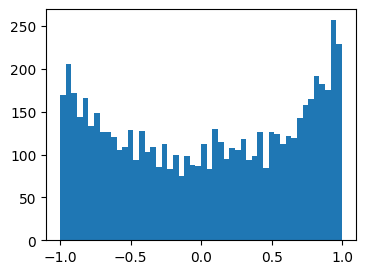

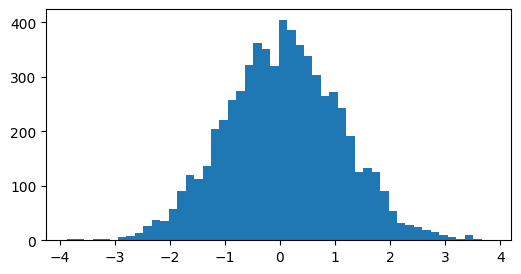

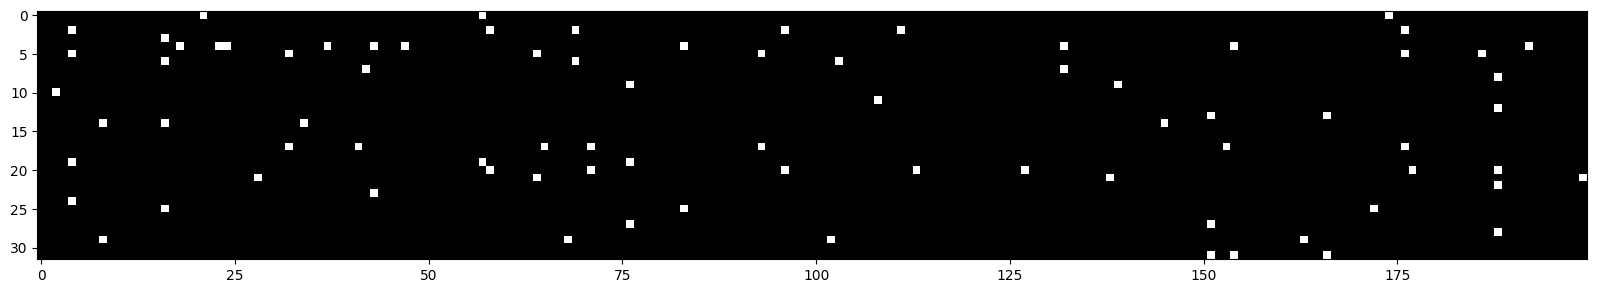

In [127]:
# values of activation:

print(h.shape, h.view(-1).shape)
lst =  h.view(-1).tolist()
plt.figure(figsize=(4, 3))
plt.hist(lst,50)
plt.plot()


# values before activation triggered
plt.figure(figsize=(6, 3))
plt.hist(hpreact.view(-1).tolist(), 50)
plt.plot()

print(f"shape of activation:\n{h.shape}")
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap= 'gray', interpolation='nearest')

11897
      0/   5000: 3.7477
    500/   5000: 2.9541
   1000/   5000: 2.4541
   1500/   5000: 2.1060
   2000/   5000: 2.4049
   2500/   5000: 2.3513
   3000/   5000: 2.2152
   3500/   5000: 2.5592
   4000/   5000: 2.0156
   4500/   5000: 2.3334
train 2.3564
val 2.3568


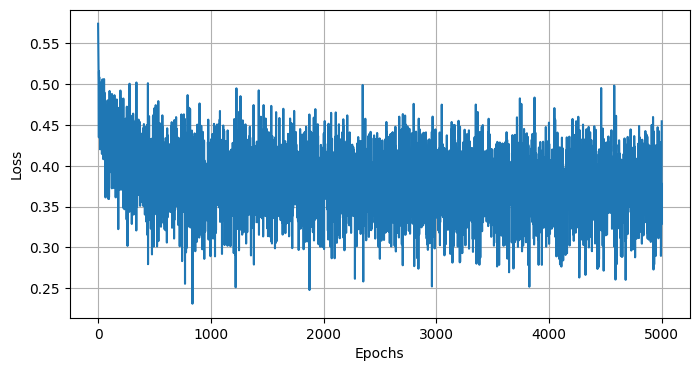

In [130]:
# now from the above graphs we can see that 
# we have solved the activation issues
#now will roun for all epochs
#-------------------------------------------


n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# Training Loop:
#------------------------------

max_steps = 5000
batch_size = 32
lossi = []


for i in range(max_steps):

    #minbatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator= g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batchs

    #forward Pass:
    emb = C[Xb]                 # emb chr into vector(32,3,10)
    embcat = emb.view(emb.shape[0],-1)       # voncat the vectors(32,30)
    hpreact = embcat @ W1 + b1    # (32,200)
    h = torch.tanh(hpreact)     # (32,200)
    logits = h @ W2 + b2        # (32,27)
    loss = F.cross_entropy(logits, Yb)

    #backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()

    #weight update:
    lr = 0.1 if i < 500 else 0.01      # step lr decay
    for p in parameters:
        p.data += -lr * p.grad

    # track status:
    if i % 500== 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    
    # plot data
    lossi.append(loss.log10().item())
    
split_loss('train')
split_loss('val')
import matplotlib.pyplot as plt
# Plot loss vs epochs
plt.figure(figsize=(8, 4))  # Set the width and height in inches
plt.plot(lossi)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [ ]:
# after seting the activation below are results

# train 2.3525
# val 2.3578


x shape: torch.Size([1000, 10])
w shape: torch.Size([10, 200])
y shape: torch.Size([1000, 200])
x mean: 0.012196 w mean:-0.049129 y mean:-0.010581
x SD 0.989946 w SD 1.019952 y SD 3.204167
x mean: 0.003141 w mean:-0.073506 y mean:0.007505
x SD 1.009675 w SD 4.972723 y SD 15.919535
x mean: 0.006935 w mean:0.001056 y mean:-0.001454
x SD 1.009692 w SD 0.473435 y SD 1.508884
x mean: 0.000212 w mean:0.009018 y mean:-0.004890
x SD 0.990460 w SD 0.310164 y SD 0.972122


[]

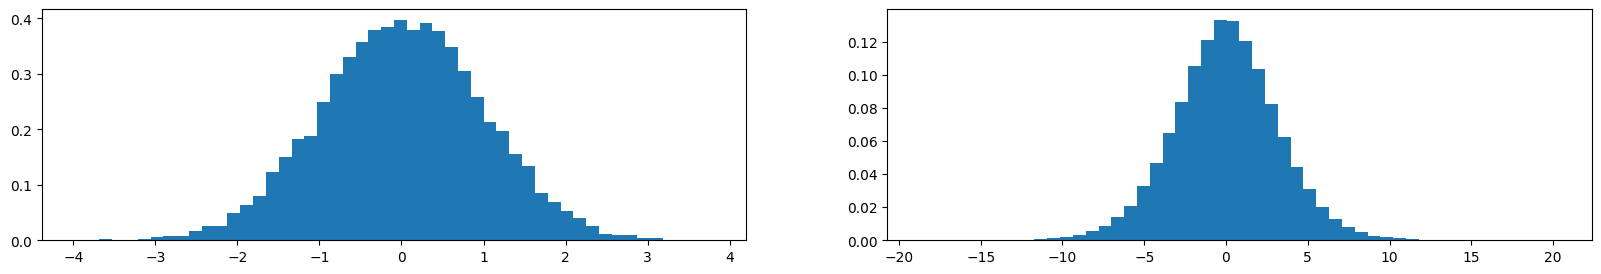

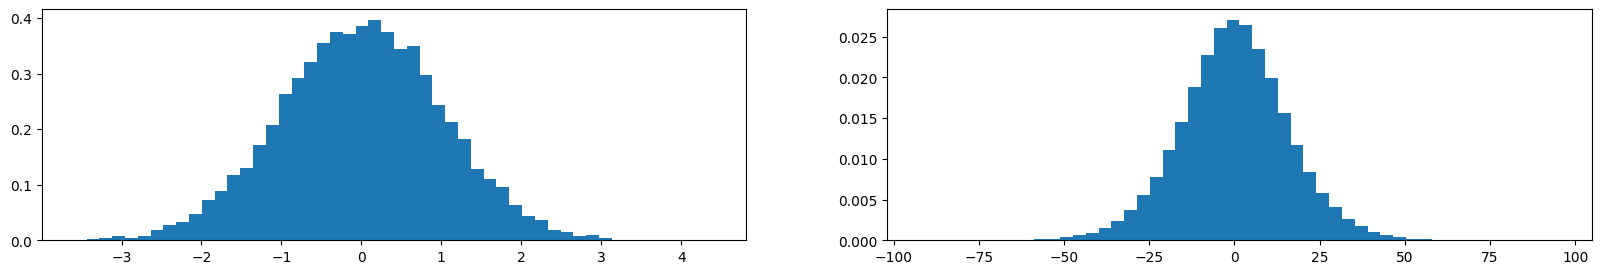

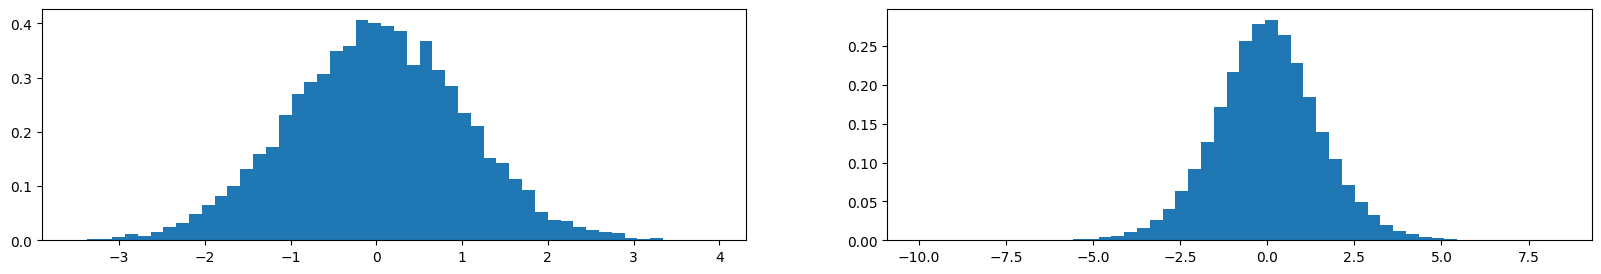

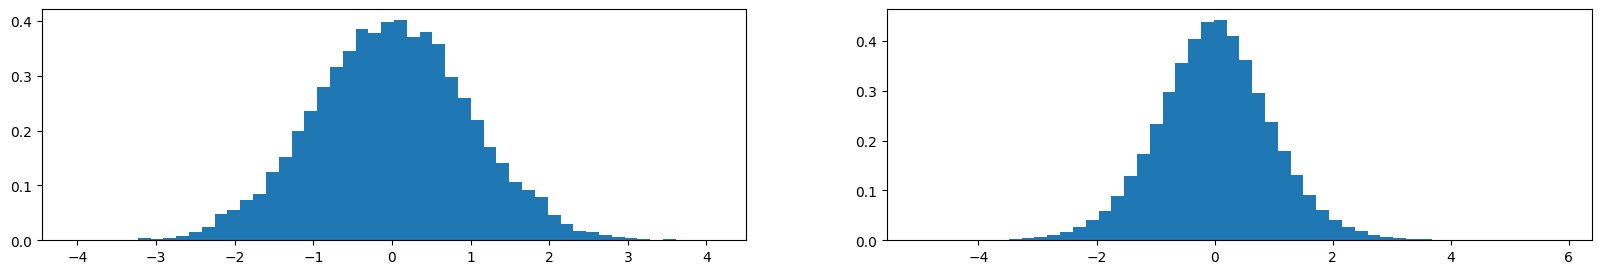

In [36]:
#
import matplotlib.pyplot as plt 
x = torch.randn(1000, 10)      # 10 inputs 
w = torch.randn(10,200)        # 200 neurons with input 10
y = x @ w

print(f"x shape: {x.shape}")
print(f"w shape: {w.shape}")
print(f"y shape: {y.shape}")

print(f"x mean: {x.mean():4f} w mean:{w.mean():4f} y mean:{y.mean():4f}")
print(f"x SD {x.std():4f} w SD {w.std():4f} y SD {y.std():4f}")

plt.figure(figsize=(20,3))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

plt.plot()



#
import matplotlib.pyplot as plt 
x = torch.randn(1000, 10)      # 10 inputs 
w = torch.randn(10,200)  * 5      # 200 neurons with input 10
y = x @ w



print(f"x mean: {x.mean():4f} w mean:{w.mean():4f} y mean:{y.mean():4f}")
print(f"x SD {x.std():4f} w SD {w.std():4f} y SD {y.std():4f}")

plt.figure(figsize=(20,3))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

plt.plot()



import matplotlib.pyplot as plt 
x = torch.randn(1000, 10)      # 10 inputs 
w = torch.randn(10,200)  * 0.5      # 200 neurons with input 10
y = x @ w



print(f"x mean: {x.mean():4f} w mean:{w.mean():4f} y mean:{y.mean():4f}")
print(f"x SD {x.std():4f} w SD {w.std():4f} y SD {y.std():4f}")

plt.figure(figsize=(20,3))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

plt.plot()


import matplotlib.pyplot as plt 
x = torch.randn(1000, 10)      # 10 inputs 
w = torch.randn(10,200)  / (10)**0.5    # 200 neurons with input 10
y = x @ w



print(f"x mean: {x.mean():4f} w mean:{w.mean():4f} y mean:{y.mean():4f}")
print(f"x SD {x.std():4f} w SD {w.std():4f} y SD {y.std():4f}")

plt.figure(figsize=(20,3))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

plt.plot()


In [ ]:
# gausian distribution 
# normal gaussian 
    # mean = 0
    # SD = 1  measure of the spread of gaussian

# after multiplicatoion
# mean remain same as it is simitric operation 
# the gaussian is expending for ie y and SD is increasing

# from the above graph as the weights value increases the spread of output y increases proportionaly
# similarly if i readuce the value of weights the output spread will decrease


# point is what do i multiply with weight to preserve the SD of output to be one
# div the sqroot of fanin 
# fanin is the input element to layer ie = 10
# root(fanin) = root(10)


# the activation out valuie shoud not convers to 0 or expend to inf 
# it should be well managed


# also the gradients should also be well behaved
# all this will be managed by well initalized weights and baises


# torch uses:
# torch.nn.init.kaining_normal


# weight initalisation used to play imp role eariler but due to advancement 
# of below techniques help it to take care of it

# batch normalisation 
# resudual connection 
# best optimiser



# gain/root(fanin)    # gain for tanh = 5/3
(5/3)/((n_embd * block_size)**0.5)

In [ ]:
# now from the above graphs we can see that 
# we have solved the activation issues
#now will roun for all epochs
#-------------------------------------------


n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# Training Loop:
#------------------------------

max_steps = 5000
batch_size = 32
lossi = []


for i in range(max_steps):

    #minbatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator= g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batchs

    #forward Pass:
    emb = C[Xb]                 # emb chr into vector(32,3,10)
    embcat = emb.view(emb.shape[0],-1)       # voncat the vectors(32,30)
    hpreact = embcat @ W1 + b1    # (32,200)
    h = torch.tanh(hpreact)     # (32,200)
    logits = h @ W2 + b2        # (32,27)
    loss = F.cross_entropy(logits, Yb)

    #backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()

    #weight update:
    lr = 0.1 if i < 500 else 0.01      # step lr decay
    for p in parameters:
        p.data += -lr * p.grad

    # track status:
    if i % 500== 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    
    # plot data
    lossi.append(loss.log10().item())
    
split_loss('train')
split_loss('val')
import matplotlib.pyplot as plt
# Plot loss vs epochs
plt.figure(figsize=(8, 4))  # Set the width and height in inches
plt.plot(lossi)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [ ]:
# batch normalisation:
#------------------------------
# will modify preactivation
# it has to be roughly gausian
# so that output to activation have right shape

# so just take the preactivations and normalised it to gaussain 
# and gaussain is perfectly differential operation

# if the preactivation is small than ytanh will inactivae
# and if it is high than tanh output will be saturated
# so we like it to be preactivation to be gausian

# we want these preactivation: hpreact to be gaussain omnnly in the initalization but not force to be gausian always
# like this distribution should move around
# so will introduce scale and shift
# we are taking these normalised input and scaling these input by some gain and adding some baise to offset them
# 
# add gain and bais
# at the initalization the value of gain =1 
# bias = 0
# so hract = gain * (hract - hract.mean()) / hract.std()  + bias

# in the optimisation these gain and bias value will get updated to give flexibility to the output value of the preactivation.


In [42]:
# now from the above graphs we can see that 
# we have solved the activation issues
#now will roun for all epochs
#-------------------------------------------


n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.0


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# Training Loop:
#------------------------------

max_steps = 5000
batch_size = 32
lossi = []


for i in range(max_steps):

    #minbatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator= g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batchs

    #forward Pass:
    emb = C[Xb]                 # emb chr into vector(32,3,10)
    embcat = emb.view(emb.shape[0],-1)       # voncat the vectors(32,30)
    hpreact = embcat @ W1 + b1    # (32,200)

    # preactivation : hpreact
    hpreact = (hpreact - hpreact.mean(0,keepdim=True)) / hpreact.std(0, keepdim=True)




    h = torch.tanh(hpreact)     # (32,200)
    logits = h @ W2 + b2        # (32,27)
    loss = F.cross_entropy(logits, Yb)

    #backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()

    #weight update:
    lr = 0.1 if i < 500 else 0.01      # step lr decay
    for p in parameters:
        p.data += -lr * p.grad

    # track status:
    if i % 500== 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    
    # plot data
    lossi.append(loss.log10().item())
    break
    


11897
      0/   5000: 3.9518


In [54]:
print(f"{hpreact.shape=}") # 32 examples 200 neurons
print(f"mean around 0 dim: {hpreact.mean(0, keepdim=True).shape=}")
print(f"SD around 0 dim: {hpreact.std(0, keepdim=True).shape=}")
print(f"batch normalization:")
hpreact = (hpreact - hpreact.mean(0,keepdim=True)) / hpreact.std(0, keepdim=True)

hpreact.shape=torch.Size([32, 200])
mean around 0 dim: hpreact.mean(0, keepdim=True).shape=torch.Size([1, 200])
SD around 0 dim: hpreact.std(0, keepdim=True).shape=torch.Size([1, 200])


12297
      0/   5000: 3.7900
    500/   5000: 2.7913
   1000/   5000: 2.3590
   1500/   5000: 2.4010
   2000/   5000: 2.3683
   2500/   5000: 2.4132
   3000/   5000: 2.4002
   3500/   5000: 2.4720
   4000/   5000: 2.2636
   4500/   5000: 2.1829


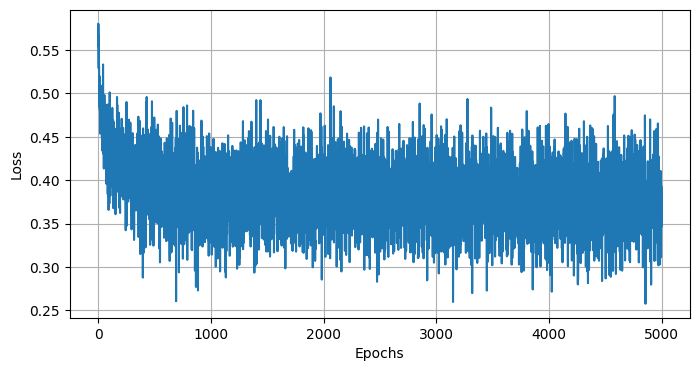

In [55]:
# add gain and bais
# at the initalization the value of gain =1 
# bias = 0
# so hract = gain * (hract - hract.mean()) / hract.std()  + bias
#-------------------------------------------


n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.0



bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# Training Loop:
#------------------------------

max_steps = 5000
batch_size = 32
lossi = []


for i in range(max_steps):

    #minbatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator= g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batchs

    #forward Pass:
    emb = C[Xb]                 # emb chr into vector(32,3,10)
    embcat = emb.view(emb.shape[0],-1)       # voncat the vectors(32,30)
    hpreact = embcat @ W1 + b1    # (32,200)

    # preactivation : hpreact
    hpreact = bngain * (hpreact - hpreact.mean(0,keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias




    h = torch.tanh(hpreact)     # (32,200)
    logits = h @ W2 + b2        # (32,27)
    loss = F.cross_entropy(logits, Yb)

    #backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()

    #weight update:
    lr = 0.1 if i < 500 else 0.01      # step lr decay
    for p in parameters:
        p.data += -lr * p.grad

    # track status:
    if i % 500== 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    
    # plot data
    lossi.append(loss.log10().item())
    
    

import matplotlib.pyplot as plt
# Plot loss vs epochs
plt.figure(figsize=(8, 4))  # Set the width and height in inches
plt.plot(lossi)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [56]:
@torch.no_grad()   # decorator will disable gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    # preactivation : hpreact
    hpreact = bngain * (hpreact - hpreact.mean(0,keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f"{split} {loss.item():.4f}")

split_loss('train')
split_loss('val')

train 2.3686
val 2.3681


In [ ]:
# after seting the activation below are results

# train 2.3525
# val 2.3578

# train 2.3686
# val 2.3681

In [57]:
# evaluation:
# evaluation on generation
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

morajansa.
zeze.
mad.
ryalarsturjksogon.
gra.
chad.
elin.
shilon.
jekeanvit.
aah.
katelon.
kaana.
shdani.
dhinie.
tyn.
joxecgynn.
thatfanzelahda.
kyltub.
eha.
kayshah.
